In [1]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor1/clones/knn_kparam_30"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/top/scrap"
cloneID_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/clones_ranked/cloneID_rank_ncells.txt"

ntop_clones = 10
p_thresh = 0.1

condition = "noInput"


In [2]:
if condition == "None" or condition is None:
    condition = None
    suffix = None
elif condition != "inputOnly" and condition != "noInput":
    raise ValueError("condition needs to be inputOnly or noInput")
else:
    if condition == "inputOnly":
        condition = "input"
    #suffix = "noInput" if condition == "noInput" else "input"
    suffix = "Cultured" if condition == "noInput" else "Input"

In [3]:
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm
from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 
import seaborn as sns
import matplotlib.pyplot as plt
from src import clonal_shifts as cs
from icecream import ic
from mplh import cluster_help as ch
plt.rcParams['svg.fonttype'] = 'none'

fig_utils from mplh


In [4]:
with open(cloneID_f, "r") as f:
    cloneIDs = f.readlines()
cloneIDs = [x.strip() for x in cloneIDs]
cloneIDs

top_cloneIDs = cloneIDs[:ntop_clones]
top_cloneIDs

['1_10', '1_0', '1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8']

In [5]:
#cells_meta = pd.read_csv(cells_meta_f, sep="\t")

In [6]:
def load_cond(indir, cond):
    hyper = pd.read_csv(join(indir, f"{cond}_hypergeo_pvals.csv"),  index_col=0)
    shuffle_df = pd.read_csv(join(indir, f"{cond}_shuffle_results_pvals.csv"), index_col=0)
    return hyper, shuffle_df

In [7]:
if (condition is not None) and (condition != ""):
    hyper = pd.read_csv(join(indir, "hypergeo_pvals.csv"),  index_col=0)
    shuffle_df = pd.read_csv(join(indir, "shuffle_results_pvals.csv"), index_col=0)
    #hyper, shuffle_df = load_cond(indir, condition)
else:
    noInput_hyper, noInput_shuffle_df = load_cond(indir, "noInput") 
    input_hyper, input_shuffle_df = load_cond(indir, "input")


# noInput_hyper = pd.read_csv(join(indir, "noInput_hypergeo_pvals.csv"),  index_col=0)
# noInput_shuffle_df = pd.read_csv(join(indir, "noInput_shuffle_results_pvals.csv"), index_col=0)

# input_hyper = pd.read_csv(join(indir, "input_hypergeo_pvals.csv"), index_col=0)
# input_shuffle_df = pd.read_csv(join(indir, "input_shuffle_results_pvals.csv"), index_col=0)



In [17]:
def create_pval(clone_d, hyper_key, shuffle_key, clustIDs, suffix=None):
    pval_df = pd.DataFrame(columns = ["hypergeo", "global_min", "clone_min", "clone_all", "global_all"],
                           index=clustIDs)
    if clone_d[shuffle_key] is None:
        if clone_d[hyper_key] is not None:
            pval_df.loc[clone_d[hyper_key].index, "hypergeo"] = clone_d[hyper_key]
            print('pval_df')
        else:
            print("no sig")
    else:
        shuff_df = clone_d[shuffle_key].pivot(index="variable", columns="method", values="value")
        shuff_df
        pval_df.loc[shuff_df.index, shuff_df.columns] = shuff_df

        if clone_d[hyper_key] is not None:
            pval_df.loc[clone_d[hyper_key].index, "hypergeo"] = clone_d[hyper_key]
    
    #pval_df.fillna(1)  
    if suffix is not None:
        pval_df.columns = [f"{x}_{suffix}" for x in pval_df.columns]
    return pval_df


def run_ind_clone_oneCond(clone_id, condition, hyper, shuffle_df, clone_d=None):
    print('clone_id', clone_id)
    if clone_d is None:
        clone_d = {}
    if clone_id in hyper.index:
        clone_d[f"{condition}_hyper"] = hyper.loc[clone_id]
    else: 
        clone_d[f"{condition}_hyper"] = None
    
    if clone_id in shuffle_df["index"].values:
        clone_d[f"{condition}_shuffle"] = shuffle_df.loc[shuffle_df["index"]==clone_id]
    else:
        clone_d[f"{condition}_shuffle"] = None
        
    set_hyper = clone_d[f'{condition}_hyper'].index if clone_d[f'{condition}_hyper'] is not None else set()
    set_shuffle = clone_d[f'{condition}_shuffle']["variable"].values if clone_d[f'{condition}_shuffle'] is not None else set()  
    return clone_d, set_hyper, set_shuffle

def run_ind_clone(clone_id, condition=None):
    if condition is None:
        clone_d, set_noInput_hyper, set_noInput_shuffle = run_ind_clone_oneCond(clone_id, condition="noInput", 
                                                                hyper=noInput_hyper, shuffle_df=noInput_shuffle_df)
        clone_d, set_input_hyper, set_input_shuffle = run_ind_clone_oneCond(clone_id, condition="input", 
                                                                hyper=input_hyper, shuffle_df=input_shuffle_df,
                                                                           clone_d=clone_d)
                                                                            
        clustIDs = set(set_input_hyper).union(set_noInput_hyper)
        clustIDs = clustIDs.union(set_noInput_shuffle).union(set_input_shuffle)
        noInput_pval_df = create_pval(clone_d, hyper_key="noInput_hyper",shuffle_key="noInput_shuffle", clustIDs=clustIDs)
        input_pval_df = create_pval(clone_d, hyper_key="input_hyper",shuffle_key="input_shuffle", clustIDs=clustIDs)
        pval_df = pd.merge(input_pval_df, noInput_pval_df, left_index=True, right_index=True, 
                           how="outer", suffixes=("_Input", "_Cultured"))
        ## Sort clusters by global_min, hypergeo, 
        pval_df = pval_df.fillna(1).sort_values(["global_min_Input", "hypergeo_Input", "clone_min_Input","global_min_Cultured", "hypergeo_Cultured",  "clone_min_Cultured"])

    else:
        clone_d, set_hyper, set_shuffle = run_ind_clone_oneCond(clone_id, condition=condition, 
                                                                hyper=hyper, shuffle_df=shuffle_df)        
        clustIDs = set(set_hyper).union(set_shuffle)
        pval_df = create_pval(clone_d, hyper_key=f"{condition}_hyper",shuffle_key=f"{condition}_shuffle", 
                              clustIDs=clustIDs, suffix=suffix).fillna(1)        
    return pval_df

In [18]:
pval_d = {}
for c_id in top_cloneIDs:
    pval_d[c_id] = run_ind_clone(c_id, condition=condition)

clone_id 1_10
clone_id 1_0
clone_id 1_1
clone_id 1_2
clone_id 1_3
clone_id 1_4
clone_id 1_5
clone_id 1_6
clone_id 1_7
clone_id 1_8


In [21]:
def calc_clone_sig_score(i, pval_d, suffix, sig_d):
    curr_cols = pval_d[i].columns[pval_d[i].columns.str.contains(f"_{suffix}")]
    pval_bin = (pval_d[i]<p_thresh)
    curr_sig = pd.Series(index=pval_bin.index, name=i)
    curr_sig.loc[:] = 0
    curr_sig.loc[(pval_bin[f"hypergeo_{suffix}"]==True)] = 1
    curr_sig.loc[(pval_bin[f"hypergeo_{suffix}"]==True) & (pval_bin[f"global_all_{suffix}"]==True) ] = 2
    curr_sig.loc[(pval_bin[f"hypergeo_{suffix}"]==True) & (pval_bin[f"global_all_{suffix}"]==True)
                      & (pval_bin[f"clone_min_{suffix}"]==True)] = 3
    curr_sig.loc[(pval_bin[f"hypergeo_{suffix}"]==True) & (pval_bin[f"global_all_{suffix}"]==True)
                      & (pval_bin[f"clone_min_{suffix}"]==True) & (pval_bin[f"global_min_{suffix}"]==True)] = 4    
    sig_d.append(curr_sig)
    return sig_d

def run_sig_score(pval_d, condition=None, suffix=None):
    if condition is None:
        sig_input_d = []
        sig_cultured_d = []
        for i in pval_d:
            sig_input_d = calc_clone_sig_score(i, pval_d, suffix="Input", sig_d=sig_input_d)
            sig_cultured_d = calc_clone_sig_score(i, pval_d, suffix="Cultured", sig_d=sig_cultured_d)
        sig_input_df = pd.concat(sig_input_d, axis=1).fillna(0)
        sig_cultured_df = pd.concat(sig_cultured_d, axis=1).fillna(0)
        melt_sig_input = sig_input_df.transpose().reset_index().melt(id_vars='index')
        melt_sig_input["cond"] = "Input"
        melt_sig_cultured = sig_cultured_df.transpose().reset_index().melt(id_vars='index')
        melt_sig_cultured["cond"] = "Cultured"
        merge_sig_df = pd.concat((melt_sig_input, melt_sig_cultured))
    else:
        sig_d = []
        for i in pval_d:
            sig_d = calc_clone_sig_score(i, pval_d, suffix, sig_d)
        sig_df = pd.concat(sig_d, axis=1).fillna(0)
        melt_sig = sig_df.transpose().reset_index().melt(id_vars='index')
        melt_sig["cond"] = suffix
        merge_sig_df = melt_sig
    return merge_sig_df

In [22]:
merge_sig_df = run_sig_score(pval_d, condition=condition, suffix=suffix)
merge_sig_df

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,index,variable,value,cond
0,1_10,MPP/CMP/GMP,0.0,Cultured
1,1_0,MPP/CMP/GMP,0.0,Cultured
2,1_1,MPP/CMP/GMP,0.0,Cultured
3,1_2,MPP/CMP/GMP,0.0,Cultured
4,1_3,MPP/CMP/GMP,0.0,Cultured
...,...,...,...,...
115,1_4,erythroid,0.0,Cultured
116,1_5,erythroid,2.0,Cultured
117,1_6,erythroid,0.0,Cultured
118,1_7,erythroid,0.0,Cultured


In [23]:
def plot_hyper_sig(data, **kwargs):
    #print(data.head())
    data.pivot(index="variable", columns="index", values="value").plot.bar(ax=plt.gca())
    sns.heatmap(data.pivot(index="variable", columns="index", values="value"), ax=plt.gca(),
               vmax=4, vmin=0)
    return


In [ ]:
# sig_input_d = []
# sig_cultured_d = []

# for i in pval_d:
#     print(i)
#     curr_input_cols = pval_d[i].columns[pval_d[i].columns.str.contains("_Input")]
#     curr_cultured_cols = pval_d[i].columns[pval_d[i].columns.str.contains("_Cultured")]
#     curr_cultured_cols

#     pval_bin = (pval_d[i]<p_thresh)
    
#     curr_sig_input = pd.Series(index=pval_bin.index, name=i)
#     curr_sig_input.loc[:] = 0
    
#     curr_sig_input.loc[(pval_bin["hypergeo_Input"]==True)] = 1
#     curr_sig_input.loc[(pval_bin["hypergeo_Input"]==True) & (pval_bin["global_all_Input"]==True) ] = 2
#     curr_sig_input.loc[(pval_bin["hypergeo_Input"]==True) & (pval_bin["global_all_Input"]==True)
#                       & (pval_bin["clone_min_Input"]==True)] = 3
#     curr_sig_input.loc[(pval_bin["hypergeo_Input"]==True) & (pval_bin["global_all_Input"]==True)
#                       & (pval_bin["clone_min_Input"]==True) & (pval_bin["global_min_Input"]==True)] = 4    
#     sig_input_d.append(pd.DataFrame(curr_sig_input))
    
#     curr_sig_cultured = pd.Series(index=pval_bin.index, name=i)
#     curr_sig_cultured.loc[:] = 0
#     curr_sig_cultured.loc[(pval_bin["hypergeo_Cultured"]==True)] = 1
#     curr_sig_cultured.loc[(pval_bin["hypergeo_Cultured"]==True) & (pval_bin["global_all_Cultured"]==True)] = 2
#     curr_sig_cultured.loc[(pval_bin["hypergeo_Cultured"]==True) & (pval_bin["global_all_Cultured"]==True)
#                            & (pval_bin["clone_min_Cultured"]==True)] = 3  
#     curr_sig_cultured.loc[(pval_bin["hypergeo_Cultured"]==True) & (pval_bin["global_all_Cultured"]==True)
#                           & (pval_bin["clone_min_Cultured"]==True) & (pval_bin["global_min_Cultured"]==True)] = 4       
        
#     sig_cultured_d.append(pd.DataFrame(curr_sig_cultured))

# sig_input_df = pd.concat(sig_input_d, axis=1).fillna(0)
# sig_input_df

# sig_cultured_df = pd.concat(sig_cultured_d, axis=1).fillna(0)
# sig_cultured_df

# # merge_sig_df = sig_input_df.transpose()
# # merge_sig_df

# melt_sig_input = sig_input_df.transpose().reset_index().melt(id_vars='index')
# melt_sig_input["cond"] = "input"
# melt_sig_cultured = sig_cultured_df.transpose().reset_index().melt(id_vars='index')
# melt_sig_cultured["cond"] = "cultured"
# merge_sig_df = pd.concat((melt_sig_input, melt_sig_cultured))
# merge_sig_df

FileNotFoundError: [Errno 2] No such file or directory: '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/top/scrap/top10_sig_hypergeo.svg'

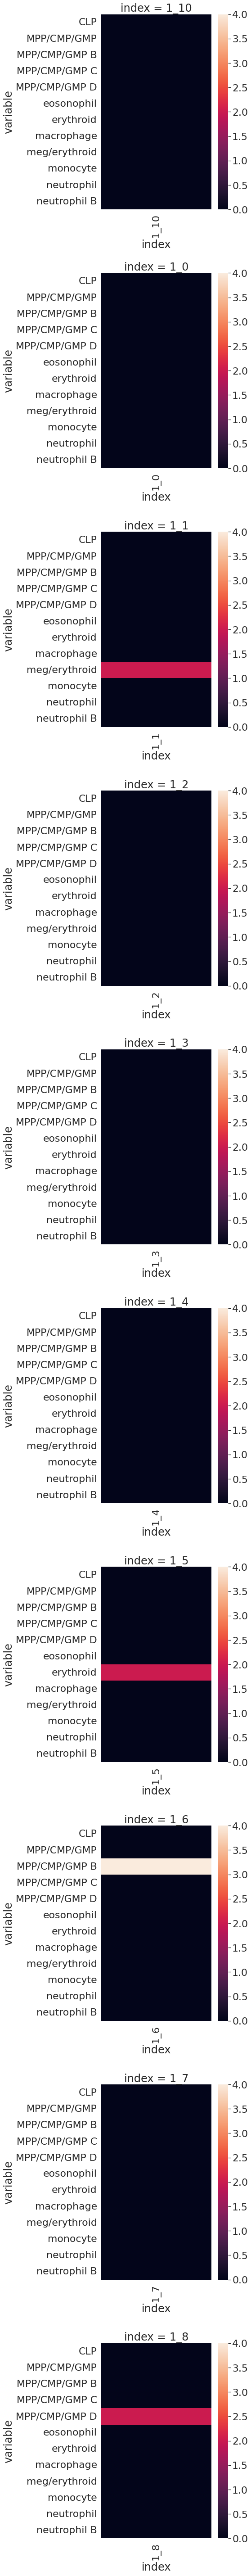

In [24]:
if condition is None:
    sns.set(font_scale=2)
    g = sns.FacetGrid(data=merge_sig_df, col="cond", row='index',
                      row_order=top_cloneIDs, col_order=["Input", "Cultured"],
                      sharex=False, sharey=False, height=8, aspect=1)
    g.map_dataframe(plot_hyper_sig)

    g.fig.savefig(fname=join(outdir, f"top{ntop_clones}_sig_hypergeo.svg"), bbox_inches='tight', pad_inches=0.5)

else:
    sns.set(font_scale=2)
    g = sns.FacetGrid(data=merge_sig_df, row='index',
                      row_order=top_cloneIDs, sharex=False, sharey=False, height=8, aspect=1)
    g.map_dataframe(plot_hyper_sig)

    g.fig.savefig(fname=join(outdir, f"top{ntop_clones}_sig_hypergeo.svg"), bbox_inches='tight', pad_inches=0.5)
    